In [9]:
# third-party
import pickle
import pandas as pd

# local
from results_generator import write_results
from get_data import get_participant_ids
from get_data import get_data_by_id_activity
from constants import ACTIVITIES_LIST

In [10]:
acquisition_folderpath = 'Aquisicao'
id_participants = get_participant_ids(acquisition_folderpath)
data, data_raw = get_data_by_id_activity(acquisition_folderpath)

Getting data for participants...
 --------- 7OYX ---------------
 --------- NO15 ---------------
 --------- G8B7 ---------------
 --------- EPE2 ---------------
 --------- HAK8 ---------------
 --------- 1BST ---------------
 --------- 83J1 ---------------
 --------- QMQ7 ---------------
 --------- 9TUL ---------------
 --------- FTD7 ---------------
 --------- Y6O3 ---------------
 --------- 2QWT ---------------
 --------- F9AF ---------------
 --------- P4W9 ---------------
 --------- W8Z9 ---------------
 --------- D4GQ ---------------


In [11]:
print('Writing results...')
for id in id_participants:
    print(' ---------',id,'---------------')
    write_results(id, data[id], data_raw[id], acquisition_folderpath, show_fig=False)

Writing results...
 --------- 7OYX ---------------
 --------- NO15 ---------------
 --------- G8B7 ---------------
 --------- EPE2 ---------------
 --------- HAK8 ---------------
 --------- 1BST ---------------
 --------- 83J1 ---------------
 --------- QMQ7 ---------------
    Could not find key 'MIXB'
 --------- 9TUL ---------------
 --------- FTD7 ---------------
 --------- Y6O3 ---------------
 --------- 2QWT ---------------


/Users/anasofiacc/dev/M-RESP/results_generator.py:65: RuntimeWarning: invalid value encountered in scalar divide
  br_pzt = (60*len(tb_pzt)) / np.sum(tb_pzt)
/Users/anasofiacc/dev/M-RESP/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/anasofiacc/dev/M-RESP/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/anasofiacc/dev/M-RESP/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/anasofiacc/dev/M-RESP/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anasofiacc/dev/M-RESP/.venv/lib/python3.9/site-packages/numpy/core/

 --------- F9AF ---------------
 --------- P4W9 ---------------
 --------- W8Z9 ---------------
 --------- D4GQ ---------------


SNB


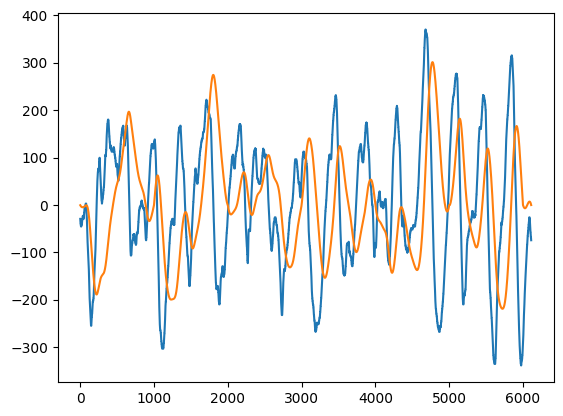

SGB


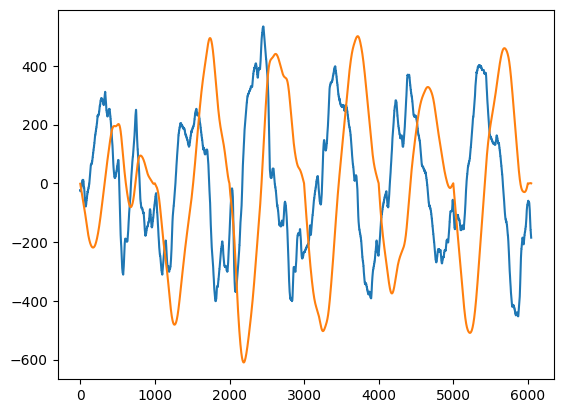

MCH


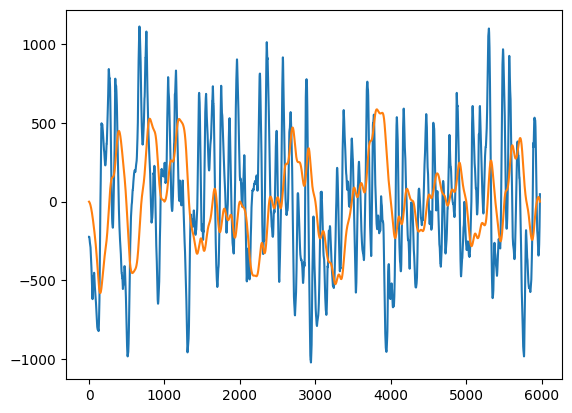

SQT


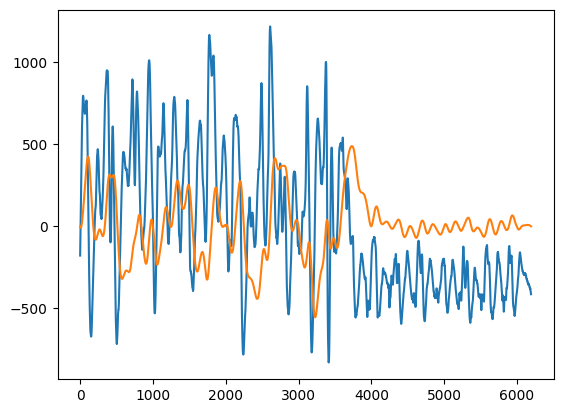

MIXB


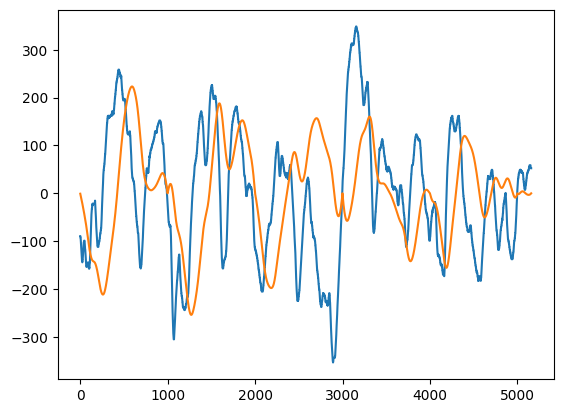

STNB


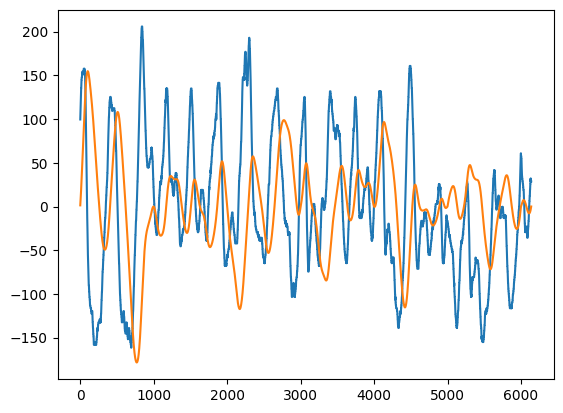

AAL


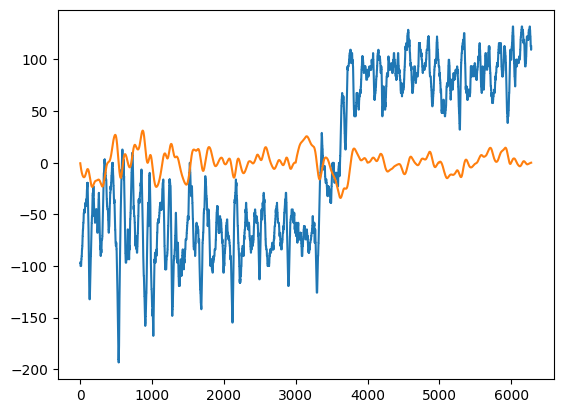

AAR


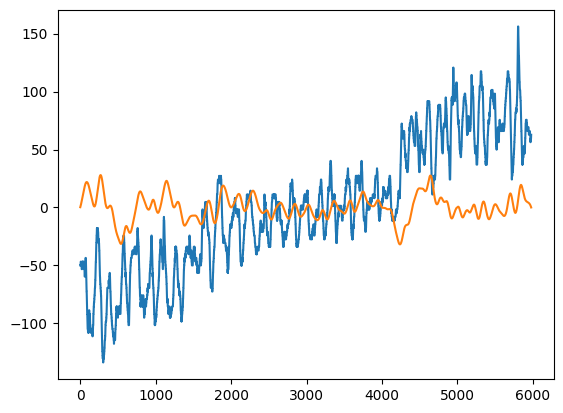

ALL


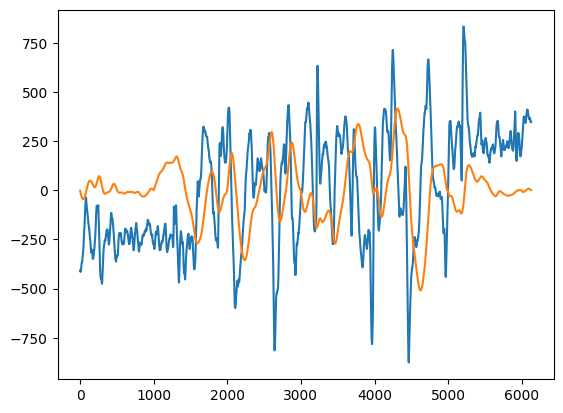

ALR


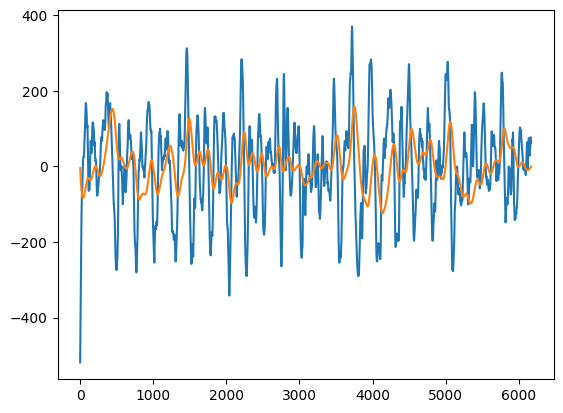

UAL


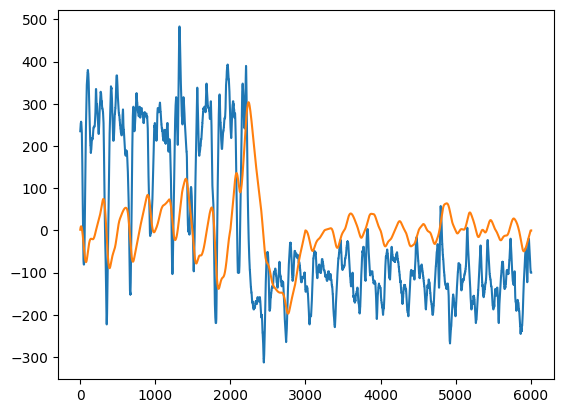

UAR


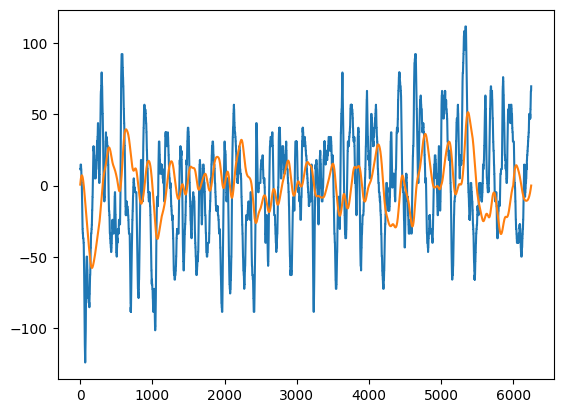

SE


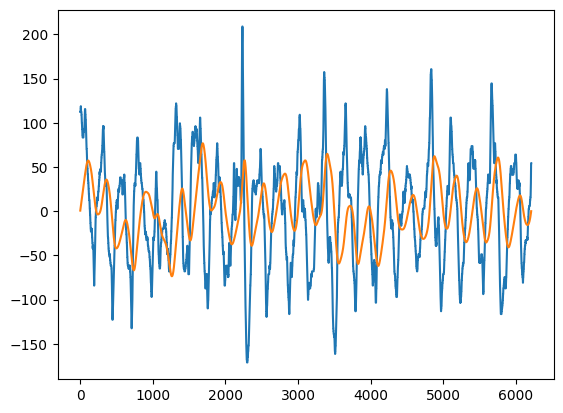

SS


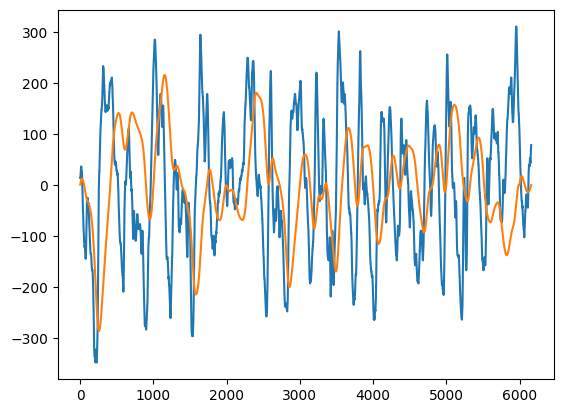

TR


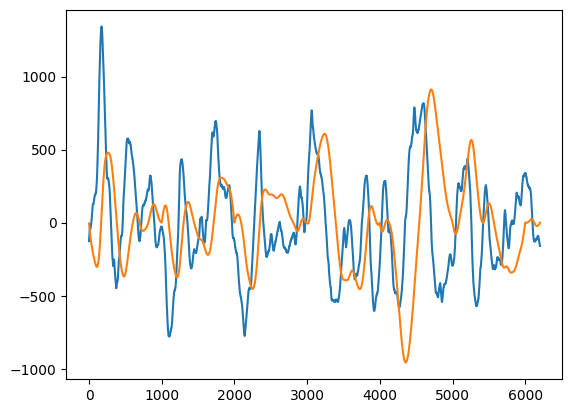

In [12]:
import matplotlib.pyplot as plt
for activity in ACTIVITIES_LIST:
    raw = data_raw['Y6O3'][activity]['pzt'] - data_raw['Y6O3'][activity]['pzt'].mean()
    processed = data['Y6O3'][activity]['pzt'] - data['Y6O3'][activity]['pzt'].mean()
    print(activity)
    plt.figure()
    plt.plot(raw)
    plt.plot(processed)
    plt.show()




In [13]:
with open('Results/results.pickle', 'rb') as file:
    data = pickle.load(file)

In [14]:
overview = pd.DataFrame(columns=["participant_id", "activity", "FR events", "complete cycles", "BR"])


for id in id_participants:
    print('---------',id,'---------------')
    
    new_entry = {"participant_id": id}

    for activity in ACTIVITIES_LIST:
        try:
            new_entry["activity"] = activity
            new_entry["FR events"] = len(data[id][activity]["Airflow"]["peaks"]) + len(data[id][activity]["Airflow"]["valleys"])
            new_entry["complete cycles"] = len(data[id][activity]["Airflow"]["tB (s)"])
            new_entry["BR"] = data[id][activity]["Airflow"]["BR (bpm)"]

            overview.loc[len(overview)] = new_entry
        
        except KeyError as e:
            print(f"    Could not find key {e}")
            continue

overview

--------- 7OYX ---------------
--------- NO15 ---------------
--------- G8B7 ---------------
--------- EPE2 ---------------
--------- HAK8 ---------------
--------- 1BST ---------------
--------- 83J1 ---------------
--------- QMQ7 ---------------
--------- 9TUL ---------------
--------- FTD7 ---------------
--------- Y6O3 ---------------
--------- 2QWT ---------------
--------- F9AF ---------------
--------- P4W9 ---------------
--------- W8Z9 ---------------
--------- D4GQ ---------------


,participant_id,activity,FR events,complete cycles,BR
0,7OYX,SNB,29,12,13.090909
1,7OYX,SGB,13,4,5.908419
2,7OYX,MCH,22,10,9.789525
3,7OYX,SQT,24,10,12.305168
4,7OYX,MIXB,24,10,16.137708
...,...,...,...,...,...
235,D4GQ,UAL,22,9,11.031665
236,D4GQ,UAR,21,8,10.745467
237,D4GQ,SE,21,10,10.209290
238,D4GQ,SS,19,9,9.303928


In [15]:
# get data where activity is not UALm, UARm, SNBm
removed_middle = overview[~overview["activity"].isin(["UALm", "UARm", "SNBm"])]
print(f"mean BR: {removed_middle['BR'].mean()}")
print(f"FR events: {removed_middle['FR events'].sum()}")
print(f"complete cycles: {removed_middle['complete cycles'].sum()}")

mean BR: 14.678031256139885
FR events: 7246
complete cycles: 3264


In [16]:
overview_by_activity = pd.DataFrame(columns=["activity", "BR [bpm]", "FR events", "complete cycles"])

for activity in ACTIVITIES_LIST:
    new_entry = {"activity": activity}
    activity_data = overview[overview["activity"] == activity]
    new_entry["FR events"] = activity_data["FR events"].sum()
    new_entry["complete cycles"] = activity_data["complete cycles"].sum()
    new_entry["BR [bpm]"] = activity_data["BR"].mean().round(2)
    overview_by_activity.loc[len(overview_by_activity)] = new_entry

overview_by_activity

,activity,BR [bpm],FR events,complete cycles
0,SNB,13.40,451,200
1,SGB,5.89,195,73
2,MCH,15.20,504,228
3,SQT,16.50,541,245
4,MIXB,12.57,391,168
5,STNB,13.18,455,209
6,AAL,16.50,542,248
7,AAR,16.48,538,244
8,ALL,17.37,569,258
9,ALR,17.02,565,257
